In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
forecasted_info = pd.read_csv("ForecastedInformation.csv")

### Helper Functions for Differential Evolution

In [ ]:
# Creates a population with population size rows and 2N columns (1 for each parameter)
def initialize_population(bounds, population_size):
    population = np.zeros((population_size, len(bounds)))
    for i in range(len(bounds)):
        population[:, i] = np.random.uniform(bounds[i][0], bounds[i][1], population_size)
    return population



In [ ]:
def mutate(individual_index, population, mutation_factor, bounds):
    indices = np.array([i for i in range(len(population)) if i != individual_index])
    selected_indices = np.random.choice(indices, 3, replace=False)
    a, b, c = population[selected_indices[0]], population[selected_indices[1]], population[selected_indices[2]]
    mutant = a + mutation_factor * (b - c)
    mutant = np.clip(mutant, [bound[0] for bound in bounds], [bound[1] for bound in bounds])
    return mutant

In [8]:
def crossover(target, mutant, crossover_prob):
    # Generate a mask based on the crossover probability
    mask = np.random.rand(len(target)) < crossover_prob
    # Apply the mask to choose elements from the mutant
    trial = np.where(mask, mutant, target)
    return trial

In [9]:
def differential_evolution(objective_function, parameter_bounds, population_size, n_generations, mutation_factor, p_crossover):
    # Initialize population and maintain current fitnesses
    population = initialize_population(parameter_bounds, population_size)
    fitness = np.array([objective_function(individual) for individual in population])

    for _ in range(n_generations):
        
        new_population = population.copy()
        for i in range(population_size):
            # Mutation
            mutant = mutate(i, population, mutation_factor, parameter_bounds)
            # Crossover
            trial = crossover(population[i], mutant, p_crossover)
            # Evaluation
            trial_fitness = objective_function(trial)
            if trial_fitness > fitness[i]:
                new_population[i] = trial
                fitness[i] = trial_fitness
    best_index = np.argmax(fitness)
    return population[best_index], fitness[best_index]

### Inputs to the function

In [ ]:
# Generate bounds for each SKU
num_skus = len(forecasted_info["Pcode"].unique())

# Policy decision period
max_order_frequency = 10 # In weeks, this is up to the user!

# Parameters are a 2*num_skus by 2 matrix
# Each entry contains array of upper and lower bound
parameter_bounds = np.zeros((2*num_skus, 2))
# All lower bounds remain 0
for i, sku in enumerate(forecasted_info["Pcode"].unique()):
    temp_df = forecasted_info[forecasted_info["Pcode"] == sku]
    parameter_bounds[2*i][1] = int(temp_df["Quantity Sold"].max())
    parameter_bounds[2*i+1][1] = max_order_frequency

# Some additional hyperparameters to tune of differential evolution
population_size = 100 
n_generations = 100 # This is QUITE susceptible to change
mutation_factor = 1 # This has to be a constant from 0 to 2
p_crossover = 0.3 # between 0 and 1

### Define objective functions and variables that it needs

In [5]:
# Variable definitions
num_skus = num_skus # As defined above
policy_optimization_period = 5 # Should equal max_order_frequency from above
df = forecasted_info # Contains all info about each sku
# Should convert it into the following form:
skus = forecasted_info["Pcode"].unique()
# Then convert this into the forms we want for optimization
prices = np.zeros((num_skus, 1))
forecast_weeks = [104, 105, 106, 107, 108] # Somehow, need to relate this to policy optimization period
quantities = np.zeros((num_skus, len(forecast_weeks)))
for j, sku in enumerate(skus):
    temp_df = forecasted_info[forecasted_info["Pcode"] == sku]
    prices[j] = (temp_df.iloc[0]["Price"][1:])
    # ELIZA TODO: figure out why accidentally created duplicates when created the forecasted information df
    quantity_df = temp_df[temp_df["Week"].isin(forecast_weeks)].iloc[0:len(forecast_weeks)]
    quantities[j] = np.array(quantity_df["Quantity Sold"])
# NOW: prices and quantities have the info we need

In [73]:
# Define objective function based on values above
def f(individual):
    # Individual is a list of 2N values which is parameters for each SKU in the space
    # Combination of 1) Missed Sales 2) Inventory 3) Cost of buying stuff

    # Calculation of Missed Sales

    # For each SKU, start with first order simulation by getting even individual entries
    sku_quantities = np.zeros((num_skus, 1))
    frequencies = individual[1::2]
    # Then starting at the first week, try to enact the policy
    missed_sales = 0
    inventory = 0
    reorder_cost = 0
    for i in range(0, policy_optimization_period): 
        # Calculate the amount from that week from the df
        # Subtract it from the sku_quantity
        for j in range(num_skus):
            # Account for potential restock (but don't double count the first week)
            if frequencies[j] % i == 0:
                sku_quantities[j] += individual[2*j] # Add the amount from reorder

                # Cost of buying stuff (reorder_cost)
                # TODO: Sidd, can you change the costs to be nonzero amounts even though we would fabricate this data somehow
                # NOTE: I am currently pretending the cost is just 1
                reorder_cost += 1 # Here, instead, we would just do cost[j] or whever but we need a cost array

            # quantities j i is the amount of sku j sold in week i
            sku_quantities[j] = sku_quantities[j] - quantities[j][i]
            if sku_quantities[j] < 0:
                missed_sales += (-1)*sku_quantities[j]*prices[j] #-1 because sku quantities is negative here and we add to missed sales
                sku_quantities[j] = 0

        # This just calculates the inventory quantity
        inventory += sum(sku_quantities) # TODO Sidd- you can add all your notes about how much space each takes up and whatever here
    
    return missed_sales + inventory + reorder_cost

In [53]:
#### DIFFERENTIAL EVOLUTION INPUTS ####
objective_function = f
parameter_bounds = parameter_bounds
populationSize = population_size
n_generations = n_generations
mutation_factor = mutation_factor
p_crossover = 0.3

best_parameters, score = differential_evolution(objective_function, parameter_bounds, population_size, n_generations, mutation_factor, p_crossover)

print (best_parameters, score)

C:\Users\sidrt\AppData\Local\Temp\ipykernel_18156\3888204175.py:16: RuntimeWarning: divide by zero encountered in remainder
  restock_mask = np.where(reorder_frequencies > 0, (time_steps % reorder_frequencies == 0), False)


[174.76157464  10.           0.         ...  10.           0.
   0.        ] 11687047.33493526


In [27]:
print (best_parameters, score)

[229.07947312   8.45946037  86.24246842 ...   8.99518016 631.67895432
   2.4105119 ] [11454984.49902288]


Next steps
(Sidd, def do the ones I put your name by and hopefully the rest of them too except for 5 lol)
(also, currently takes 2.5 minutes to run which def we cld cut down! compare to this number for stats)
1. Make the objective function significantly faster (remove for loops)
2. Figure out how to use numpy to remove the inner for loop in the algorithm
3. (Sidd) allow the inventory and reorder cost to take in the volumes and cost of reordering each indiviudal item / fix them if they are not how u want them
4. Implement hyperparameter search– what does this mean? For populationSize, n_generations, mutation_factor and p_crossover, run the algorithm for a grid of specific quantities and find the best set of these configurations that allow for lowest score (we have to be careful about the best way to do this, might be some sort of optimization as well– Sidd you can think through this)
5. (Eliza) figure out why the ForecastedInformation.csv has duplicates lol (I just removed them for now)
6. Benchmark our progress– not sure how we would do this– lmk what you think Sidd

NOTE: user inputs
- policy_optimization_period
- forecast_weeks (which exact weeks of df we are forecasting)

## Sidd notes:

- Initial run (no changes to code): 8.25 mins


In [3]:
def initialize_population(bounds, population_size):
    bounds = np.array(bounds, dtype=np.float64)  # Convert bounds to a NumPy array
    lower_bounds = bounds[:, 0]
    upper_bounds = bounds[:, 1]
    rng = np.random.default_rng(seed=42)
    population = rng.uniform(lower_bounds, upper_bounds, (population_size, len(bounds)))
    return population

In [11]:
def differential_evolution(
    objective_function, parameter_bounds, population_size, n_generations, mutation_factor, p_crossover,
    quantities, prices_flat, policy_optimization_period, num_skus, a, b, c
):
    # Initialize population and current fitnesses
    population = initialize_population(parameter_bounds, population_size)
    fitness = np.array([
        objective_function(ind, quantities, prices_flat, policy_optimization_period, num_skus, a, b, c)
        for ind in population
    ])

    bounds_array = np.array(parameter_bounds)
    lower_bounds, upper_bounds = bounds_array[:, 0], bounds_array[:, 1]

    for _ in range(n_generations):
        # Mutation and crossover in a vectorized manner
        indices = np.arange(population_size)
        a_indices = np.random.choice(indices, size=population_size, replace=True)
        b_indices = np.random.choice(indices, size=population_size, replace=True)
        c_indices = np.random.choice(indices, size=population_size, replace=True)

        # Ensure indices are not equal to the current individual
        valid = a_indices != indices
        a_indices[~valid] = (a_indices[~valid] + 1) % population_size

        # Calculate mutants
        a, b, c = population[a_indices], population[b_indices], population[c_indices]
        mutants = a + mutation_factor * (b - c)
        mutants = np.clip(mutants, lower_bounds, upper_bounds)

        # Ensure reorder amounts and frequencies are integers
        mutants = np.round(mutants)

        # Perform crossover
        crossover_mask = np.random.rand(population_size, len(parameter_bounds)) < p_crossover
        trial_population = np.where(crossover_mask, mutants, population)

        # Evaluate the new population
        trial_fitness = np.array([
            objective_function(ind, quantities, prices_flat, policy_optimization_period, num_skus, a, b, c)
            for ind in trial_population
        ])

        # Update population and fitness using a loop
        for i in range(population_size):
            if trial_fitness[i] < fitness[i]:
                population[i] = trial_population[i]
                fitness[i] = trial_fitness[i]

    best_index = np.argmin(fitness)  # Minimize the objective
    return population[best_index], fitness[best_index]


In [5]:
# Generate bounds for each SKU
num_skus = len(forecasted_info["Pcode"].unique())

# Policy decision period
max_order_frequency = 5 # In weeks, this is up to the user!

# Parameters are a 2*num_skus by 2 matrix
# Each entry contains array of upper and lower bound
parameter_bounds = np.zeros((2*num_skus, 2))
# All lower bounds remain 0
for i, sku in enumerate(forecasted_info["Pcode"].unique()):
    temp_df = forecasted_info[forecasted_info["Pcode"] == sku]
    parameter_bounds[2*i][1] = int(temp_df["Quantity Sold"].max())
    parameter_bounds[2*i+1][1] = max_order_frequency

# Some additional hyperparameters to tune of differential evolution
population_size = 24 
n_generations = 349 # This is QUITE susceptible to change
mutation_factor = 0.1216607094073362 # This has to be a constant from 0 to 2
p_crossover = 0.18024817208001548 # between 0 and 1
a = 0.1
b = 1
c = 1

In [9]:
# Variable definitions
num_skus = num_skus # As defined above
policy_optimization_period = 5 # Should equal max_order_frequency from above
df = forecasted_info # Contains all info about each sku
# Should convert it into the following form:
skus = forecasted_info["Pcode"].unique()
# Then convert this into the forms we want for optimization
prices = np.zeros((num_skus, 1))
prices_flat = prices.ravel()
forecast_weeks = [104, 105, 106, 107, 108] # Somehow, need to relate this to policy optimization period
quantities = np.zeros((num_skus, len(forecast_weeks)))
for j, sku in enumerate(skus):
    temp_df = forecasted_info[forecasted_info["Pcode"] == sku]
    prices[j] = (temp_df.iloc[0]["Price"][1:])
    # ELIZA TODO: figure out why accidentally created duplicates when created the forecasted information df
    quantity_df = temp_df[temp_df["Week"].isin(forecast_weeks)].iloc[0:len(forecast_weeks)]
    quantities[j] = np.array(quantity_df["Quantity Sold"])
# NOW: prices and quantities have the info we need

In [ ]:
def f(individual, quantities, prices_flat, policy_optimization_period, num_skus, a, b, c):
    # Extract reorder quantities and frequencies from the individual
    reorder_quantities = np.array(individual[0::2], dtype=int)
    reorder_frequencies = np.array(individual[1::2], dtype=int)

    # Initialize SKU quantities and costs
    sku_quantities = np.zeros((policy_optimization_period, num_skus), dtype=np.float64)
    missed_sales = np.zeros(num_skus, dtype=np.float64)
    inventory = np.zeros(policy_optimization_period, dtype=np.float64)
    reorder_cost = np.zeros(num_skus, dtype=np.float64)

    # Create a matrix of time steps
    time_steps = np.arange(1, policy_optimization_period + 1).reshape(-1, 1)

    # Compute restock mask using broadcasting
    adjusted_frequencies = np.where(reorder_frequencies > 0, reorder_frequencies, np.inf)
    restock_mask = (time_steps % adjusted_frequencies) == 0
    restock_mask = np.where(adjusted_frequencies == np.inf, False, restock_mask)

    # Calculate reorder amounts
    reorder_amounts = restock_mask * reorder_quantities
    sku_quantities += np.cumsum(reorder_amounts, axis=0)

    # Subtract demand week by week
    demand_matrix = quantities.T
    sku_quantities -= demand_matrix

    # Calculate missed sales where stock is negative
    missed_stock = np.minimum(sku_quantities, 0)
    missed_sales += np.sum(-missed_stock * prices_flat, axis=0)
    sku_quantities = np.maximum(sku_quantities, 0)

    # Calculate reorder costs
    reorder_cost += np.sum(restock_mask, axis=0)

    # Calculate inventory cost as total stock across all weeks
    inventory += np.sum(sku_quantities, axis=1)

    # Return the total cost: missed sales + inventory holding + reorder costs
    # total_cost = np.sum(missed_sales, dtype=np.float64) + np.sum(inventory, dtype=np.float64) + np.sum(reorder_cost, dtype=np.float64)
    
    #weights are not working for some fucking reason
    total_cost = (0 * np.sum(missed_sales, dtype=np.float64)) + (1 * np.sum(inventory, dtype=np.float64)) + (0  * np.sum(reorder_cost, dtype=np.float64))
    
    return total_cost


In [44]:
#### DIFFERENTIAL EVOLUTION INPUTS ####
objective_function = f
parameter_bounds = parameter_bounds
populationSize = population_size
n_generations = n_generations
mutation_factor = 0.8
p_crossover = p_crossover

best_parameters, score = differential_evolution(objective_function, parameter_bounds, population_size, n_generations, mutation_factor, p_crossover, quantities, prices_flat, policy_optimization_period, num_skus, a, b, c)

print (best_parameters, score)

[354.   0.   0. ...   2.   0.   0.] 402609.2932286045


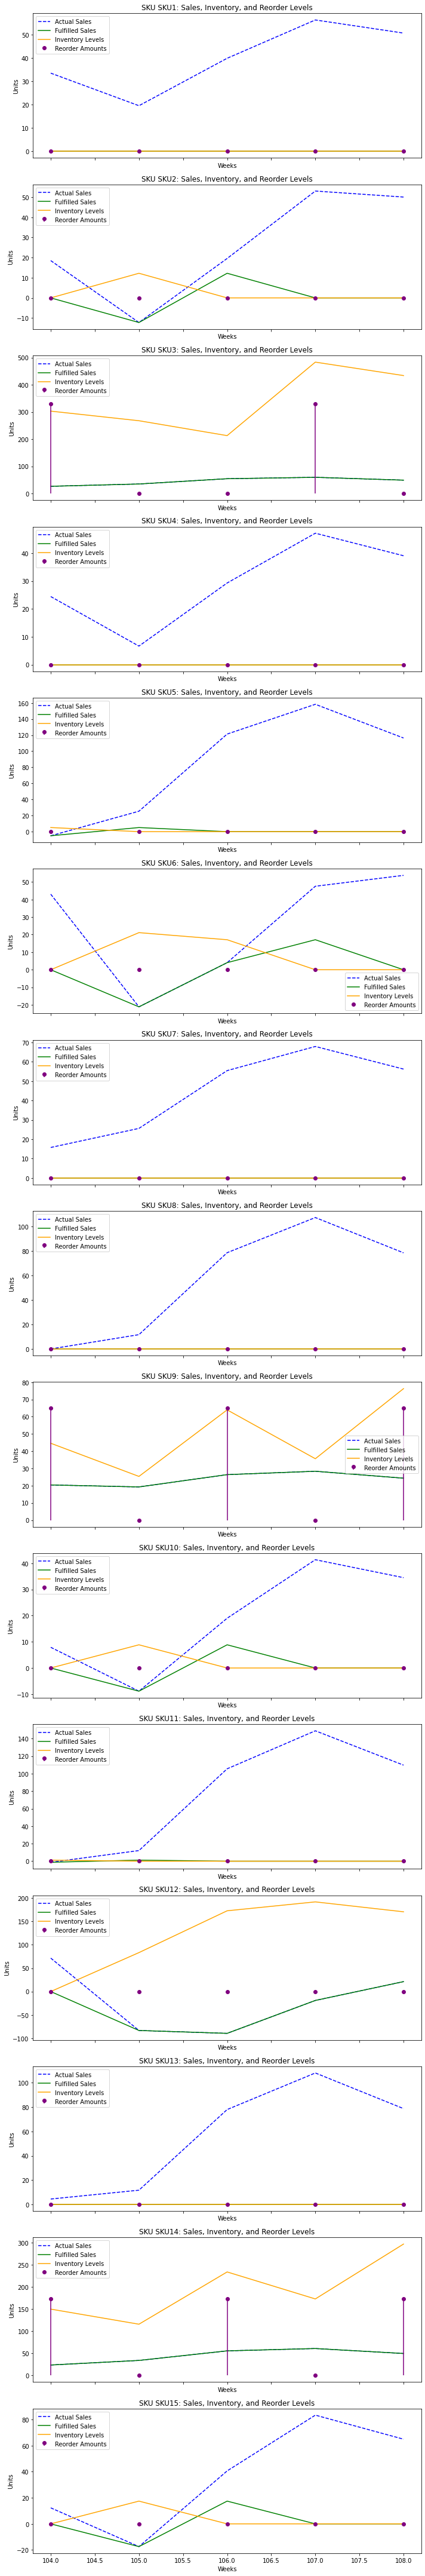

In [45]:
# Corrected simulation of fulfilled sales and inventory
reorder_quantities = np.array(best_parameters[0::2], dtype=int)
reorder_frequencies = np.array(best_parameters[1::2], dtype=int)

fulfilled_sales = np.zeros_like(quantities)
inventory_levels = np.zeros((num_skus, policy_optimization_period))

for sku in range(num_skus):
    inventory = 0  # Initial inventory
    for week in range(policy_optimization_period):
        # Reorder only if reorder frequency > 0 and it's a reorder week
        if reorder_frequencies[sku] > 0 and week % reorder_frequencies[sku] == 0:
            inventory += reorder_quantities[sku]

        # Fulfill sales based on inventory and demand
        fulfilled_sales[sku, week] = min(inventory, quantities[sku, week])
        inventory -= fulfilled_sales[sku, week]

        # Track inventory levels
        inventory_levels[sku, week] = inventory

# Correct reorder tracking
reorder_weeks = np.zeros((num_skus, policy_optimization_period))
for sku in range(num_skus):
    if reorder_frequencies[sku] > 0:
        reorder_weeks[sku, ::reorder_frequencies[sku]] = reorder_quantities[sku]

# Plotting
fig, axes = plt.subplots(15, 1, figsize=(10, 4 * 15), sharex=True)

for sku, ax in enumerate(axes):
    ax.plot(forecast_weeks, quantities[sku], label="Actual Sales", color="blue", linestyle="--")
    ax.plot(forecast_weeks, fulfilled_sales[sku], label="Fulfilled Sales", color="green")
    ax.plot(forecast_weeks, inventory_levels[sku], label="Inventory Levels", color="orange")
    ax.stem(forecast_weeks, reorder_weeks[sku], label="Reorder Amounts", linefmt="purple", markerfmt="o", basefmt=" ")
    ax.set_title(f"SKU {skus[sku]}: Sales, Inventory, and Reorder Levels")
    ax.set_xlabel("Weeks")
    ax.set_ylabel("Units")
    ax.legend()

plt.tight_layout()
plt.show()


# # 3. Missed Sales by SKU
# plt.figure()
# plt.bar(skus[:10], missed_sales)
# plt.title("Missed Sales by SKU")
# plt.xlabel("SKU")
# plt.ylabel("Total Missed Sales")
# plt.show()

# # 4. Cost Components Breakdown
# cost_sums = {k: np.sum(v) for k, v in cost_components.items()}
# plt.figure()
# plt.pie(cost_sums.values(), labels=cost_sums.keys(), autopct='%1.1f%%')
# plt.title("Cost Components Breakdown")
# plt.show()

# # 5. Total Cost Over Generations (Optional Placeholder)
# generations = np.arange(20)
# total_costs = np.random.uniform(1000, 2000, len(generations))  # Replace with actual costs if available
# plt.figure()
# plt.plot(generations, total_costs)
# plt.title("Total Cost Over Generations")
# plt.xlabel("Generation")
# plt.ylabel("Total Cost")
# plt.show()


In [101]:
import optuna

# Define the objective function for Optuna
def objective(trial):
    # Suggest values for each hyperparameter
    population_size = trial.suggest_int('population_size', 20, 500)
    n_generations = trial.suggest_int('n_generations', 10, 500)
    mutation_factor = trial.suggest_float('mutation_factor', 0.1, 2.0)
    p_crossover = trial.suggest_float('p_crossover', 0.1, 0.9)
    
    # Call your differential evolution function with the suggested hyperparameters
    _, score = differential_evolution(
        objective_function=f,
        parameter_bounds=parameter_bounds,
        population_size=int(population_size),
        n_generations=int(n_generations),
        mutation_factor=mutation_factor,
        p_crossover=p_crossover
    )
    return score  # The goal is to minimize this score

# Create an Optuna study
study = optuna.create_study(direction='minimize')  # 'minimize' to minimize the score

# Optimize the objective function
study.optimize(objective, n_trials=50)  # n_trials = number of optimization iterations

# Extract best hyperparameters and score
best_hyperparameters = study.best_params
best_score = study.best_value

print("Best Hyperparameters:", best_hyperparameters)
print("Best Score:", best_score)


[I 2024-11-28 03:37:21,027] A new study created in memory with name: no-name-9b731a62-a1fd-4508-bbe5-0b7a805ba1fb
C:\Users\sidrt\AppData\Local\Temp\ipykernel_18156\1752546027.py:18: RuntimeWarning: divide by zero encountered in remainder
  restock_mask = np.where(reorder_frequencies > 0, (time_steps % reorder_frequencies == 0), False)
[I 2024-11-28 03:37:24,878] Trial 0 finished with value: 8709297.49620713 and parameters: {'population_size': 125, 'n_generations': 152, 'mutation_factor': 0.6102412562543238, 'p_crossover': 0.319072894444884}. Best is trial 0 with value: 8709297.49620713.
[I 2024-11-28 03:37:36,320] Trial 1 finished with value: 9214265.026953124 and parameters: {'population_size': 299, 'n_generations': 181, 'mutation_factor': 1.5555993973273796, 'p_crossover': 0.35911304206281636}. Best is trial 0 with value: 8709297.49620713.
[I 2024-11-28 03:37:56,987] Trial 2 finished with value: 9255330.365895625 and parameters: {'population_size': 318, 'n_generations': 290, 'mutatio

Best Hyperparameters: {'population_size': 24, 'n_generations': 349, 'mutation_factor': 0.1216607094073362, 'p_crossover': 0.18024817208001548}
Best Score: 3739668.2628683257


### Sanity Check Cases

1.  Case 1: No Demand

    -   Description: If there's no demand (`quantities` is all zeros), the algorithm should not reorder anything, resulting in zero missed sales, zero inventory costs, and zero reorder costs.
    -   Expected Outcome:
        -   `Total Cost = 0`
        -   `Missed Sales = 0`
        -   `Inventory Cost = 0`
        -   `Reorder Cost = 0`
2.  Case 2: Constant Demand, Reorder Frequency Matches Period

    -   Description: Constant demand of 10 units per week over 5 weeks, with reorder quantities and frequencies perfectly matching demand (e.g., reorder 10 units every week).
    -   Expected Outcome:
        -   `Missed Sales = 0`
        -   `Inventory Cost = 0` (minimal inventory, as stock is immediately consumed)
        -   `Reorder Cost` proportional to the number of reorders.
3.  Case 3: High Demand, No Reorder

    -   Description: High demand (e.g., 20 units/week) but `reorder_frequency = 0`.
    -   Expected Outcome:
        -   `Missed Sales` equal to the total demand.
        -   `Inventory Cost = 0` (no stock is held).
        -   `Reorder Cost = 0`.
4.  Case 4: Excessive Reordering

    -   Description: Demand of 5 units/week, but the algorithm orders 20 units every week.
    -   Expected Outcome:
        -   `Inventory Cost` high due to excessive stock.
        -   `Missed Sales = 0` (demand is always fulfilled).
        -   `Reorder Cost` proportional to the number of reorders and quantity.

Sanity Check: Case 1: No Demand
Quantities:
[[0. 0. 0. 0. 0.]]
Prices:
[5]
Reorder Quantities: [0]
Reorder Frequencies: [0]
Total Cost: 0.0
----------------------------------------


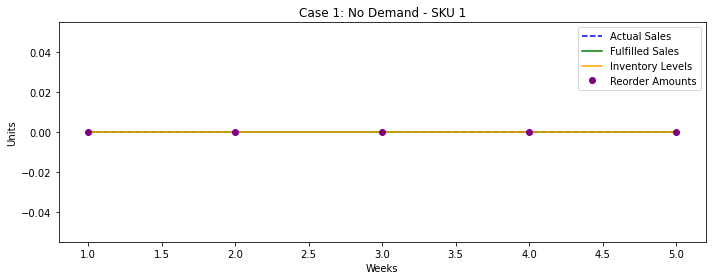

Sanity Check: Case 2: Constant Demand
Quantities:
[[10 10 10 10 10]]
Prices:
[5]
Reorder Quantities: [10]
Reorder Frequencies: [1]
Total Cost: 105.0
----------------------------------------


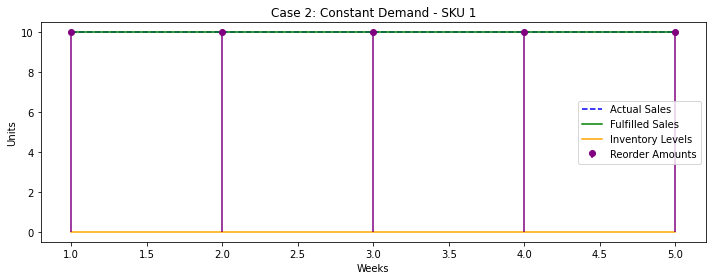

Sanity Check: Case 3: High Demand, No Reorder
Quantities:
[[20 20 20 20 20]]
Prices:
[5]
Reorder Quantities: [0]
Reorder Frequencies: [0]
Total Cost: 500.0
----------------------------------------


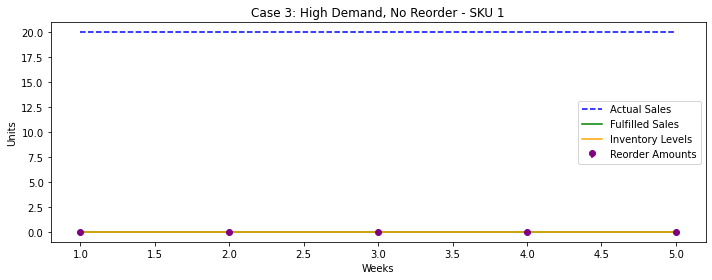

Sanity Check: Case 4: Excessive Reordering
Quantities:
[[5 5 5 5 5]]
Prices:
[5]
Reorder Quantities: [20]
Reorder Frequencies: [1]
Total Cost: 280.0
----------------------------------------


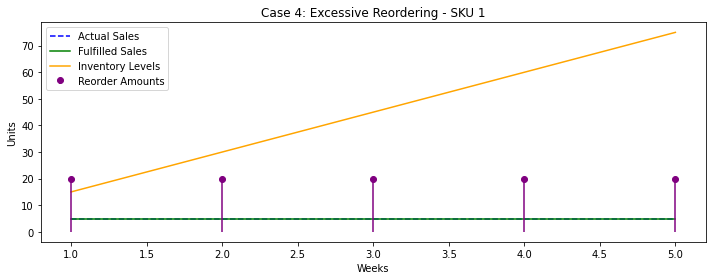

In [108]:
import numpy as np
import matplotlib.pyplot as plt

# Objective Function
def f(individual, quantities, prices_flat, policy_optimization_period, num_skus):
    reorder_quantities = np.array(individual[0::2], dtype=int)
    reorder_frequencies = np.array(individual[1::2], dtype=int)

    sku_quantities = np.zeros((policy_optimization_period, num_skus), dtype=np.float64)
    missed_sales = np.zeros(num_skus, dtype=np.float64)
    inventory = np.zeros(policy_optimization_period, dtype=np.float64)
    reorder_cost = np.zeros(num_skus, dtype=np.float64)

    time_steps = np.arange(1, policy_optimization_period + 1).reshape(-1, 1)

    adjusted_frequencies = np.where(reorder_frequencies > 0, reorder_frequencies, np.inf)
    restock_mask = (time_steps % adjusted_frequencies) == 0
    restock_mask = np.where(adjusted_frequencies == np.inf, False, restock_mask)

    reorder_amounts = restock_mask * reorder_quantities
    sku_quantities += np.cumsum(reorder_amounts, axis=0)
    demand_matrix = quantities.T
    sku_quantities -= demand_matrix

    missed_stock = np.minimum(sku_quantities, 0)
    missed_sales += np.sum(-missed_stock * prices_flat, axis=0)
    sku_quantities = np.maximum(sku_quantities, 0)

    reorder_cost += np.sum(restock_mask, axis=0)
    inventory += np.sum(sku_quantities, axis=1)

    total_cost = (
        np.sum(missed_sales, dtype=np.float64)
        + np.sum(inventory, dtype=np.float64)
        + np.sum(reorder_cost, dtype=np.float64)
    )
    return total_cost

# Visualization Function
def visualize_sanity_check(case_name, quantities, fulfilled_sales, inventory_levels, reorder_weeks, forecast_weeks):
    num_skus = quantities.shape[0]
    fig, axes = plt.subplots(num_skus, 1, figsize=(10, 4 * num_skus), sharex=True)
    
    # Ensure axes is always iterable
    if num_skus == 1:
        axes = [axes]

    for sku, ax in enumerate(axes):
        ax.plot(forecast_weeks, quantities[sku], label="Actual Sales", color="blue", linestyle="--")
        ax.plot(forecast_weeks, fulfilled_sales[sku], label="Fulfilled Sales", color="green")
        ax.plot(forecast_weeks, inventory_levels[sku], label="Inventory Levels", color="orange")
        ax.stem(forecast_weeks, reorder_weeks[sku], label="Reorder Amounts", linefmt="purple", markerfmt="o", basefmt=" ")
        ax.set_title(f"{case_name} - SKU {sku + 1}")
        ax.set_xlabel("Weeks")
        ax.set_ylabel("Units")
        ax.legend()

    plt.tight_layout()
    plt.show()

# Sanity Check Function
def sanity_check(f, case_name, quantities, prices_flat, reorder_quantities, reorder_frequencies):
    num_skus = quantities.shape[0]
    policy_optimization_period = quantities.shape[1]
    
    individual = np.empty(2 * num_skus)
    individual[0::2] = reorder_quantities
    individual[1::2] = reorder_frequencies
    
    total_cost = f(individual, quantities, prices_flat, policy_optimization_period, num_skus)
    
    # Simulate fulfilled sales and inventory
    fulfilled_sales = np.zeros_like(quantities)
    inventory_levels = np.zeros((num_skus, policy_optimization_period))
    reorder_weeks = np.zeros((num_skus, policy_optimization_period))

    for sku in range(num_skus):
        inventory = 0
        for week in range(policy_optimization_period):
            if reorder_frequencies[sku] > 0 and week % reorder_frequencies[sku] == 0:
                inventory += reorder_quantities[sku]
                reorder_weeks[sku, week] = reorder_quantities[sku]

            fulfilled_sales[sku, week] = min(inventory, quantities[sku, week])
            inventory -= fulfilled_sales[sku, week]
            inventory_levels[sku, week] = inventory

    # Display results
    print(f"Sanity Check: {case_name}")
    print(f"Quantities:\n{quantities}")
    print(f"Prices:\n{prices_flat}")
    print(f"Reorder Quantities: {reorder_quantities}")
    print(f"Reorder Frequencies: {reorder_frequencies}")
    print(f"Total Cost: {total_cost}")
    print("-" * 40)

    forecast_weeks = np.arange(1, policy_optimization_period + 1)
    visualize_sanity_check(case_name, quantities, fulfilled_sales, inventory_levels, reorder_weeks, forecast_weeks)

# Run Sanity Checks
sanity_check(
    f, "Case 1: No Demand", 
    np.zeros((1, 5)), 
    np.array([5]), 
    np.array([0]), 
    np.array([0])
)

sanity_check(
    f, "Case 2: Constant Demand", 
    np.full((1, 5), 10), 
    np.array([5]), 
    np.array([10]), 
    np.array([1])
)

sanity_check(
    f, "Case 3: High Demand, No Reorder", 
    np.full((1, 5), 20), 
    np.array([5]), 
    np.array([0]), 
    np.array([0])
)

sanity_check(
    f, "Case 4: Excessive Reordering", 
    np.full((1, 5), 5), 
    np.array([5]), 
    np.array([20]), 
    np.array([1])
)


### Sanity Check Cases

1.  One Super Expensive SKU

    -   Scenario: One SKU is very expensive compared to others. The algorithm should prioritize minimizing missed sales for the expensive SKU, even at the cost of higher inventory/reorder costs for cheaper SKUs.
    -   Expected Behavior:
        -   Fulfilled sales prioritize the expensive SKU.
        -   Missed sales for the expensive SKU are minimized.
2.  Three Equally Priced SKUs with Different Demands

    -   Scenario: All SKUs have the same price but different demand levels. The algorithm should aim to meet the highest demand first, balancing inventory and reorder costs.
    -   Expected Behavior:
        -   Higher-demand SKUs are prioritized.
        -   Lower-demand SKUs may have higher missed sales if resources are constrained.
3.  Three Equally Priced SKUs with the Same Demand

    -   Scenario: All SKUs have the same price and demand levels. The algorithm should distribute inventory and reorder decisions equally across SKUs.
    -   Expected Behavior:
        -   Fulfilled sales, inventory, and reorder costs are evenly distributed.
4.  One SKU with Zero Price

    -   Scenario: One SKU has no associated cost (e.g., a free sample or promotional item). The algorithm should ignore its missed sales cost while optimizing other SKUs.
    -   Expected Behavior:
        -   No inventory costs for the free SKU.
        -   Resources are allocated to other SKUs.
5.  Two SKUs with Constant Demand, One with High Demand

    -   Scenario: Two SKUs have moderate constant demand, and one has high demand. The algorithm should balance missed sales with inventory holding costs.
    -   Expected Behavior:
        -   High-demand SKU is prioritized, but not at the cost of extreme inventory.

Sanity Check: Case 1: One Super Expensive SKU
Quantities:
[[10 10 10 10 10]
 [ 5  5  5  5  5]
 [ 8  8  8  8  8]]
Prices:
[100  10  10]
Reorder Quantities: [10  5  8]
Reorder Frequencies: [1 2 3]
Total Cost: 328.0
----------------------------------------


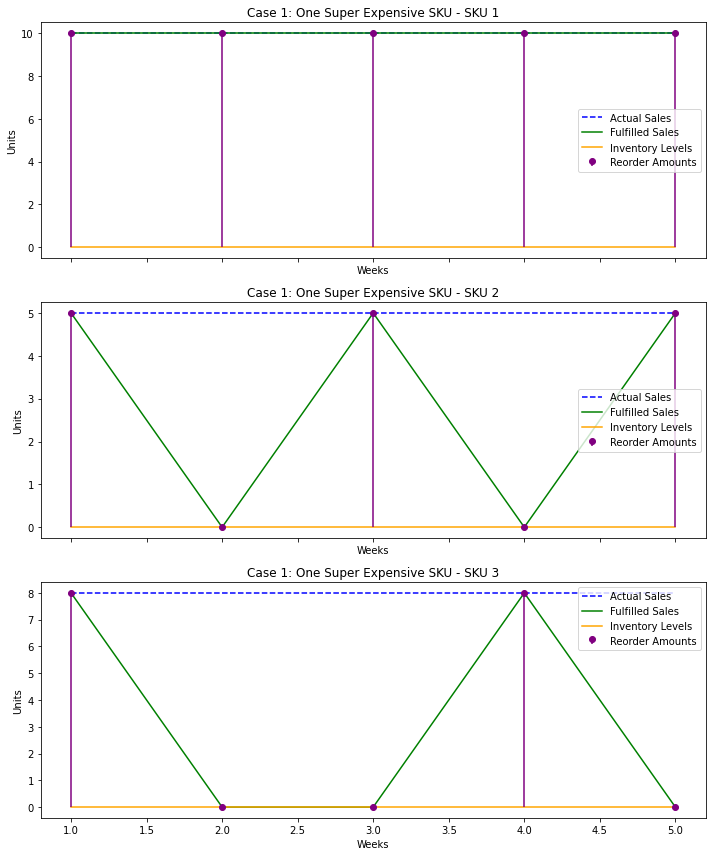

Sanity Check: Case 2: Three Equally Priced with Different Demands
Quantities:
[[10 10 10 10 10]
 [20 20 20 20 20]
 [ 5  5  5  5  5]]
Prices:
[10 10 10]
Reorder Quantities: [10 20  5]
Reorder Frequencies: [1 2 3]
Total Cost: 448.0
----------------------------------------


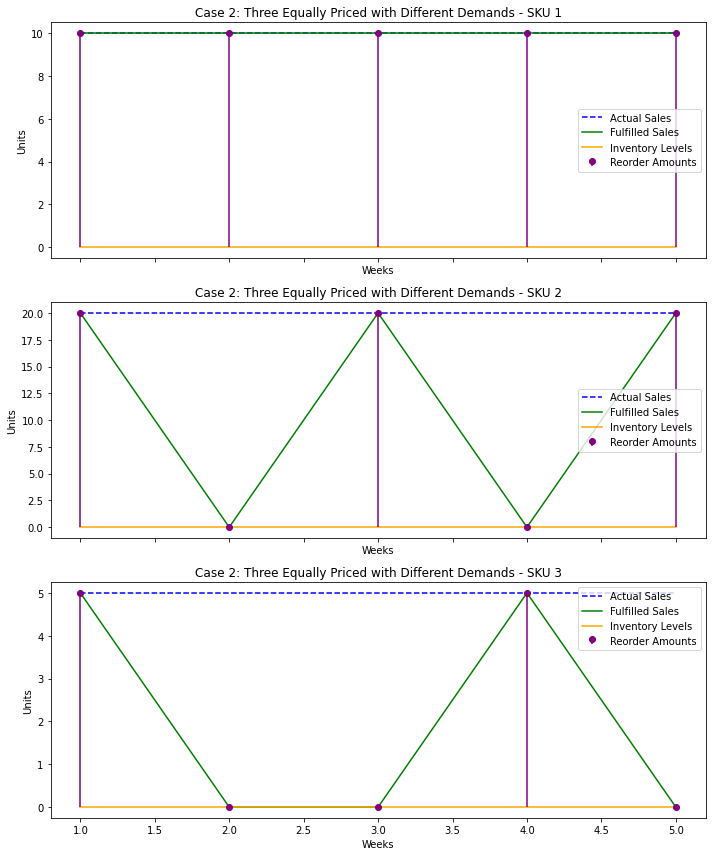

Sanity Check: Case 3: Three Equally Priced with Same Demand
Quantities:
[[10 10 10 10 10]
 [10 10 10 10 10]
 [10 10 10 10 10]]
Prices:
[10 10 10]
Reorder Quantities: [10 10 10]
Reorder Frequencies: [1 1 1]
Total Cost: 315.0
----------------------------------------


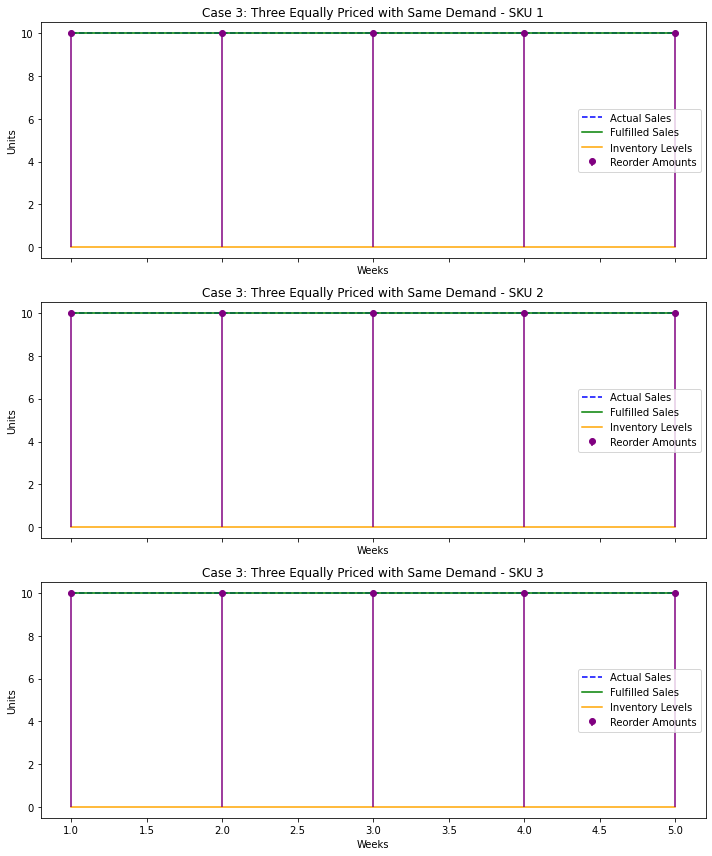

Sanity Check: Case 4: One SKU with Zero Price
Quantities:
[[10 10 10 10 10]
 [ 5  5  5  5  5]
 [ 8  8  8  8  8]]
Prices:
[ 0 10 10]
Reorder Quantities: [10  5  8]
Reorder Frequencies: [1 2 3]
Total Cost: 328.0
----------------------------------------


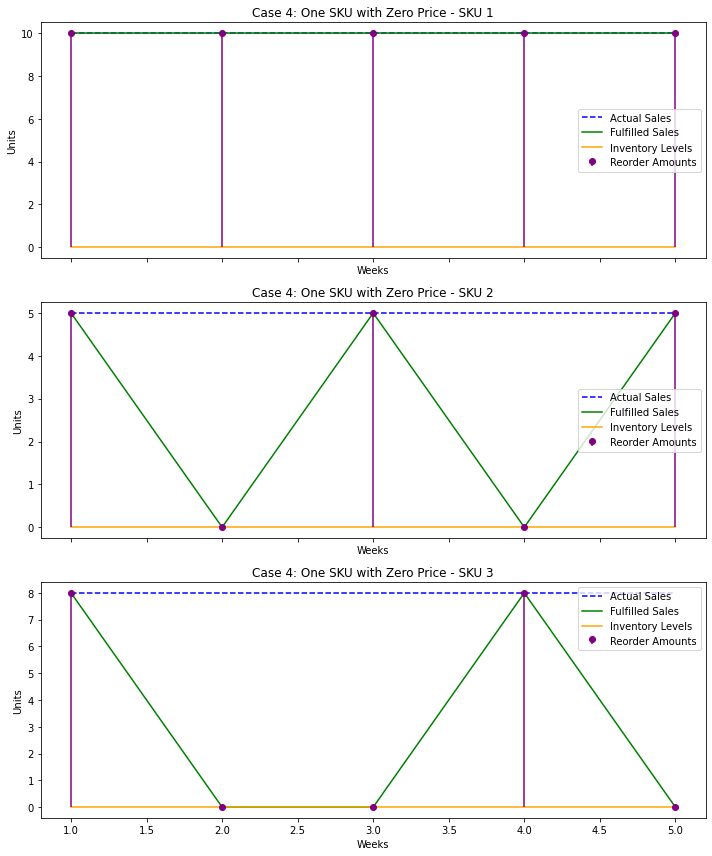

Sanity Check: Case 5: Two Constant Demands, One High Demand
Quantities:
[[10 10 10 10 10]
 [10 10 10 10 10]
 [30 30 30 30 30]]
Prices:
[10 10 10]
Reorder Quantities: [10 10 30]
Reorder Frequencies: [1 2 1]
Total Cost: 532.0
----------------------------------------


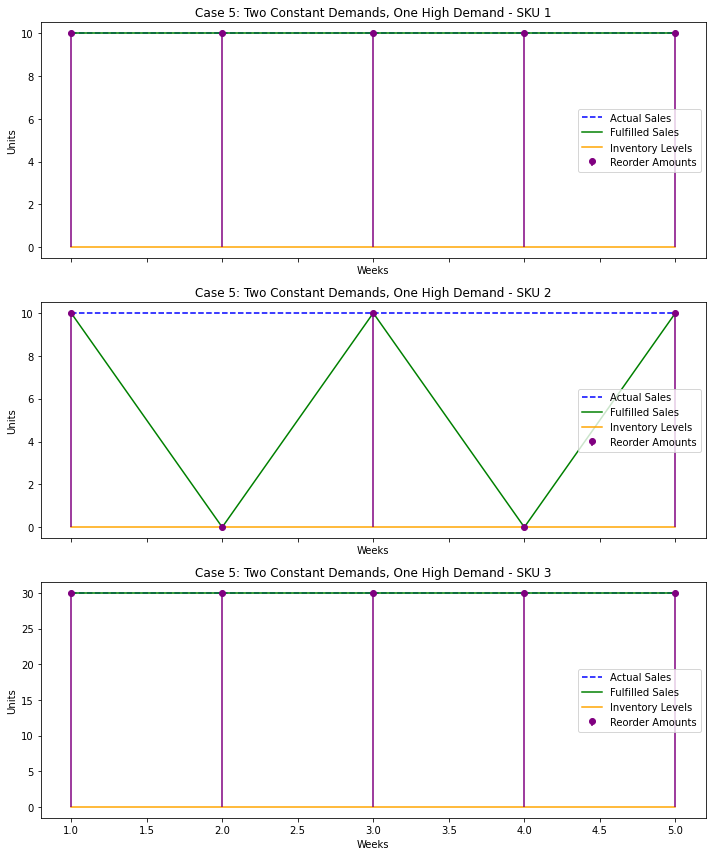

In [111]:
# Additional sanity checks
sanity_check(
    f, "Case 1: One Super Expensive SKU", 
    np.array([[10, 10, 10, 10, 10], [5, 5, 5, 5, 5], [8, 8, 8, 8, 8]]), 
    np.array([100, 10, 10]), 
    np.array([10, 5, 8]), 
    np.array([1, 2, 3])
)

sanity_check(
    f, "Case 2: Three Equally Priced with Different Demands", 
    np.array([[10, 10, 10, 10, 10], [20, 20, 20, 20, 20], [5, 5, 5, 5, 5]]), 
    np.array([10, 10, 10]), 
    np.array([10, 20, 5]), 
    np.array([1, 2, 3])
)

sanity_check(
    f, "Case 3: Three Equally Priced with Same Demand", 
    np.array([[10, 10, 10, 10, 10], [10, 10, 10, 10, 10], [10, 10, 10, 10, 10]]), 
    np.array([10, 10, 10]), 
    np.array([10, 10, 10]), 
    np.array([1, 1, 1])
)

sanity_check(
    f, "Case 4: One SKU with Zero Price", 
    np.array([[10, 10, 10, 10, 10], [5, 5, 5, 5, 5], [8, 8, 8, 8, 8]]), 
    np.array([0, 10, 10]), 
    np.array([10, 5, 8]), 
    np.array([1, 2, 3])
)

sanity_check(
    f, "Case 5: Two Constant Demands, One High Demand", 
    np.array([[10, 10, 10, 10, 10], [10, 10, 10, 10, 10], [30, 30, 30, 30, 30]]), 
    np.array([10, 10, 10]), 
    np.array([10, 10, 30]), 
    np.array([1, 2, 1])
)
